In [1]:
import kwant
import numpy as np
from cmath import exp
from math import pi
# For plotting
# %run matplotlib_setup.ipy
from matplotlib import pyplot
from ipywidgets import interact
import time
import sys

In [84]:
import tinyarray
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator

t=1.0
t_sc=1.0

tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])

def make_system(a=1, Delta=0.2, salt=13, U0=0.0, gn=0.0, gs=0.0, lam=0.0,
                W=200, L=200, Wsc=80, Lsc=20, t_j=0.1, mu=0.6, mu_sc=2,mu_lead=0.6, phi=0):

    def hopping(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
        # modulated hopping in y direction # does not work with vortex
#         H1=tinyarray.array([[-t*exp(1j * pi* phi * (xi + xj) * (yi - yj)),0],\
#                             [0,t*exp(-1j * pi* phi * (xi + xj) * (yi - yj))]])
#         # modulated hopping in x direction
        H1s=tinyarray.array([[-t*exp(-1j * pi* phi * (xi - xj) * (yi + yj)),0],\
                            [0,t*exp(1j * pi* phi * (xi - xj) * (yi + yj))]])
        H1=np.kron(H1s,np.eye(2))
        return H1
    
    def onsite(site, mu, gn, U0, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu + 4 * t)* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)

    def onsite_sc(site, mu_sc, gs, U0, Delta, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu_sc + 4 * t_sc)* np.kron(tau_z,np.eye(2))\
                + Delta * np.kron(tau_y,tau_y)- gs* np.kron(tau_z,tau_z)

    
    lat = kwant.lattice.square(norbs=4)
    syst = kwant.Builder()
    syst[(lat(x, y) for x in range(L) for y in range(W))] = onsite
    syst[(lat(x, y) for x in range(int(L/2-Lsc/2),int(L/2+Lsc/2) ) for y in range(Wsc))] = onsite_sc
    syst[lat.neighbors()] = hopping
    
    # Modify only those hopings in SC
    def hopping_sc(site1, site2,lam):
        h1=-t_sc* np.kron(tau_z,np.eye(2))
        xi, yi = site1.pos
        xj, yj = site2.pos
        if np.abs(xj-xi)>0:
            h2=1j*lam* np.kron(tau_z,tau_y)
        else:
            h2=1j*lam* np.kron(np.eye(2),tau_x)
        return h1+h2
    
    def inside_sc(hop):
        x, y = hop[0].tag
        return ( (int(L/2-Lsc/2)<=x<int(L/2+Lsc/2) )  and (-1<y<Wsc) )

    def hops_inside_sc(syst):
        for hop in kwant.builder.HoppingKind((1, 0), lat, lat)(syst):
            if inside_sc(hop):
                yield hop
        for hop in kwant.builder.HoppingKind((0, 1), lat, lat)(syst):
            if inside_sc(hop):
                yield hop
    syst[hops_inside_sc] = hopping_sc

    # Modify only those hopings on SC-QH bdy
    def hopping_jn(site_i, site_j, t_j, phi):
        return -t_j*np.kron(tau_z,np.eye(2))

    def crosses_ybdy(hop):
        x, y = hop[0].tag
        if y==Wsc and (int(L/2-Lsc/2) <=x< int(L/2+Lsc/2)):
            return True
        else:
            return False

    def crosses_xbdy(hop):
        x, y = hop[0].tag
        if x==int(L/2-Lsc/2) and y<Wsc :
            return True
        elif x==int(L/2+Lsc/2) and y<Wsc :
            return True
        else:
            return False

    def hops_across_xbdy(syst):
        for hop in kwant.builder.HoppingKind((1, 0), lat, lat)(syst):
            if crosses_xbdy(hop):
                yield hop
    def hops_across_ybdy(syst):                
        for hop in kwant.builder.HoppingKind((0, 1), lat, lat)(syst):
            if crosses_ybdy(hop):
                yield hop

    syst[hops_across_xbdy] = hopping_jn
    syst[hops_across_ybdy] = hopping_jn


    # leads
    def onsite_lead(site, mu_lead):
        return  (- mu_lead + 4 * t)* np.kron(tau_z,np.eye(2))

    def hopping_lead(site1, site2):
        return -t*np.kron(tau_z,np.eye(2))

    claw=-np.kron(np.eye(2),tau_z)
    sym_left = kwant.TranslationalSymmetry((-1, 0))
    left_lead = kwant.Builder(sym_left, conservation_law=claw, particle_hole=np.kron(tau_x,np.eye(2)) )
    left_lead[(lat(0, y) for y in range(0,W))] = onsite_lead
    left_lead[lat.neighbors()] = hopping
    syst.attach_lead(left_lead)
    syst.attach_lead(left_lead.reversed())

    sym_top = kwant.TranslationalSymmetry((0, 1))
    top_lead = kwant.Builder(sym_top, conservation_law=claw, particle_hole=np.kron(tau_x,np.eye(2)) )
    top_lead[(lat(x, 0) for x in range(int(L/2-L/4),int(L/2+L/4))) ] = onsite_lead
    top_lead[lat.neighbors()] = hopping_lead
    syst.attach_lead(top_lead)

    sym_bottom = kwant.TranslationalSymmetry((0, -1))
    bottom_lead = kwant.Builder(sym_bottom, particle_hole=np.kron(tau_x,np.eye(2)))
    bottom_lead[(lat(x, 0) for x in range(int(L/2-Lsc/2),int(L/2+Lsc/2))) ] = onsite_sc
    bottom_lead[lat.neighbors()] = hopping_sc
#     bottom_lead = kwant.Builder(sym_bottom, conservation_law=-tau_z, particle_hole=tau_y)
#     bottom_lead[(lat(x, 0) for x in range(int(L/2-L/4),int(L/2+L/4))) ] = onsite_lead
#     bottom_lead[lat.neighbors()] = hopping_lead
    syst.attach_lead(bottom_lead)
    
    return syst

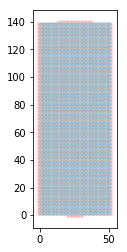

In [87]:
Wsc=120
W=Wsc+20
Lsc=12
L=Lsc+40
syst = make_system(W=W, L=L, Wsc=Wsc, Lsc=Lsc)
# Check that the system looks as intended.
# kwant.plot(syst, colorbar=False,fig_size=(10,40))
kwant.plot(syst)
# Finalize the system.
syst = syst.finalized()

(4, 29120)


/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: The plotted data contains 1.51% of values overflowing upper limit 0.616988 


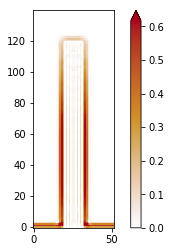

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: The plotted data contains 0.49% of values overflowing upper limit 0.0701253 


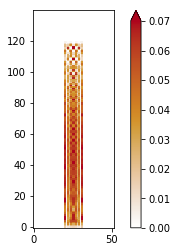

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: The plotted data contains 1.54% of values overflowing upper limit 0.00983832 


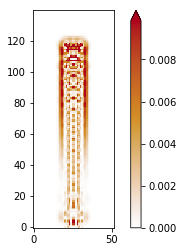

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: The plotted data contains 1.57% of values overflowing upper limit 0.0106796 


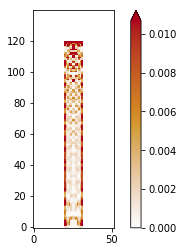

In [92]:
mu_lead=0.6
mu=0.6
mu_sc=1.5
phi=0.05
U0=0.0 # disorder strength
salt=13
Delta=0.06
t_j=0.6
gs=0.
gn=20
lam=0.4

energy=0.*Delta
params=dict(t_j=t_j, gn=gn, lam=lam, gs=gs, Delta=Delta, mu_lead=mu_lead ,mu=mu-gn,mu_sc=mu_sc,phi=phi,U0=U0,salt=salt)
wfs = kwant.wave_function(syst, energy=energy, params=params)
scattering_wf = wfs(0)  # all scattering wave functions from lead 0
# kwant.plotter.map(syst, np.sum(abs(scattering_wf[:,::2])**2, axis=0)-np.sum(abs(scattering_wf[:,1::2])**2, axis=0));
# kwant.plotter.map(syst, np.sum(abs(scattering_wf[:,1::2])**2, axis=0));
print(scattering_wf.shape)
ind=0
# fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1, 4, sharey=True, figsize=(12, 4))
# kwant.plotter.map(syst, abs(scattering_wf[ind,::4])**2-abs(scattering_wf[ind,3::4])**2,ax=ax1);
# kwant.plotter.map(syst, abs(scattering_wf[ind,1::4])**2-abs(scattering_wf[ind,2::4])**2,ax=ax2);
kwant.plotter.map(syst, abs(scattering_wf[ind,::4])**2)#,vmax=0.7);#,ax=ax1);
kwant.plotter.map(syst, abs(scattering_wf[ind,1::4])**2);#,ax=ax2);
kwant.plotter.map(syst, abs(scattering_wf[ind,2::4])**2)#,vmax=0.1);#,ax=ax3);
kwant.plotter.map(syst, abs(scattering_wf[ind,3::4])**2);#,ax=ax4);

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: The plotted data contains 1.80% of values overflowing upper limit 0.00517432 
  


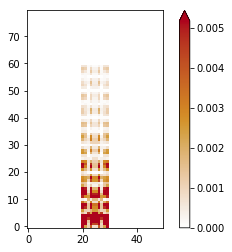

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: The plotted data contains 1.30% of values overflowing upper limit 4.21151e-26 
  import sys


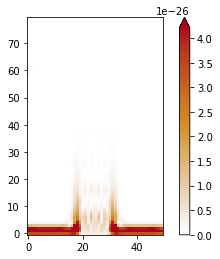

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: The plotted data contains 1.73% of values overflowing upper limit 6.33769e-28 
  


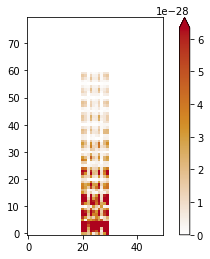

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: The plotted data contains 1.20% of values overflowing upper limit 0.368867 
  if __name__ == '__main__':


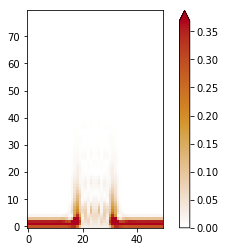

In [158]:
ind=3
# print(scattering_wf.shape)
# fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1, 4, sharey=True, figsize=(12, 4))
# kwant.plotter.map(syst, abs(scattering_wf[ind,::4])**2-abs(scattering_wf[ind,3::4])**2,ax=ax1);
# kwant.plotter.map(syst, abs(scattering_wf[ind,1::4])**2-abs(scattering_wf[ind,2::4])**2,ax=ax2);
kwant.plotter.map(syst, abs(scattering_wf[ind,::4])**2);#,ax=ax1);
kwant.plotter.map(syst, abs(scattering_wf[ind,1::4])**2);#,ax=ax2);
kwant.plotter.map(syst, abs(scattering_wf[ind,2::4])**2);#,ax=ax3);
kwant.plotter.map(syst, abs(scattering_wf[ind,3::4])**2);#,ax=ax4);

In [ ]:
mu=0.1
mu_sc=1.5
phi=0.01
U0=0.5 # disorder strength
salt=13
Delta=0.02
t_j=0.5

    pyplot.figure()
    pyplot.plot(np.array(energies)/Delta, np.array(Pe)-np.array(Ph))
#     pyplot.plot(energies, Ph)
#     pyplot.plot(energies, data)
    pyplot.xlabel("energy [Delta]")
    pyplot.ylabel(r"$P_e - P_h$")
    pyplot.show()
    
E_list=np.arange(-20, 21)*Delta/10
t_timer=time.time()
# Compute and plot the conductance
plot_conductance(syst, energies=[E for E in E_list])
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.0f " % (elapsed)+ "sec")

In [ ]:
mu_sc=1.5
phi=0.01
U0=0.5 # disorder strength
salt=13
Delta=0.02
t_j=0.5

def plot_conductance(syst, mu_sw):
    # Compute conductance
    Nrep=10
    vec=np.zeros((len(mu_sw),Nrep))
#     print(np.shape(vec))
    for salt in range(Nrep):
        print(salt, end='\r')
        for i_mu in range(len(mu_sw)):
            mu=mu_sw[i_mu]
            smatrix = kwant.smatrix(syst,energy=0,params=dict(t_j=t_j,Delta=Delta,mu=mu,mu_sc=mu_sc,phi=phi,U0=U0,salt=salt))    
            # Conductance is N - R_ee + R_he
            vec[i_mu,salt]=(smatrix.transmission((1, 0), (0, 0)) -
                        smatrix.transmission((1, 1), (0, 0)))
#         vec=vec+data
#         print([np.shape(vec),np.shape(data)])
    
    cond_avg=np.mean(vec,axis=1)
    pyplot.figure()
    pyplot.plot(np.reshape(mu_sw,[len(mu_sw),1]), vec,'b')
    pyplot.plot(np.reshape(mu_sw,[len(mu_sw),1]), cond_avg,'r')
    pyplot.xlabel(r"$\mu [t]$")
    pyplot.ylabel(r"$P_e - P_h$")
    pyplot.show()
    
# Compute and plot the conductance
plot_conductance(syst, mu_sw=[0.01 * i for i in range(5, 20)])